In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rnd
import pandas
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy import signal

from scipy.special import comb

In [2]:


def smoothstep(x, x_min=0, x_max=1, N=1):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)

    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n

    result *= x ** (N + 1)
    return result
from dataclasses import dataclass

def to_time(x):
    return x*60*2

def do_work(x, start_time, end_time, magnitude=1, reduce=False):
    l = end_time - start_time
    y1 = smoothstep(x,
                    start_time,
                    start_time+l*0.10,
                    1)
    y2= 1-smoothstep(x,
                     end_time,
                     end_time+l*0.10,
                     1)
    if reduce:
        return -y1*y2*magnitude
    else:
        return y1*y2*magnitude


def do_work_cycle(x, start_time, end_time, lengths, magnitude=1):
    
    work= np.zeros(len(x))
    t = np.linspace(start_time,end_time,len(lengths))
    #print (t)
    for l,tt in zip(lengths,t):
        work = work + \
            do_work(x,tt,tt+to_time(l), magnitude=magnitude) + \
            do_work(x,tt+to_time(l+0.3),tt+to_time(2*l*0.1+0.3), magnitude=magnitude*0.8,reduce=True)
    return work
    



In [3]:


@dataclass
class Machine_operational_specs:
    noise_factor: int
    start_time: float
    end_time : float
    start_warm_up: float
    end_cool_down: float
    machine_average_effect: int
    name: str
        
class Machine:
    def __init__(self,x,name):
        nf = rnd.random()*.8
        st= 8.00
        et= 17.00
        l = et-st
        st += rnd.normal(0.0,scale=2)
        et += rnd.normal(0.0,scale=2)
        stw = np.clip(10+rnd.normal(0.0,scale=10),0,20)
        ec = np.clip(10+rnd.normal(0.0,scale=10),0,20)
        avg = np.clip(100.0 + rnd.normal(0.0,scale=50),20,150)
        self.failure_time = 0
        self.op_spec= Machine_operational_specs(noise_factor=nf,start_time=st,
                                                end_time=et,start_warm_up=stw,end_cool_down=ec,
                                                machine_average_effect=avg,name=name)
        #print (self.op_spec)

    def __repr__(self):
        return ""+self.op_spec.__repr__()

    def save(self,path,postfix=""):
        if postfix != "":
            postfix = "_"+postfix
        with open(path+self.op_spec.name+postfix,"w+") as f:
            f.write(self.__repr__())

    def load(self, path,postfix=""):
        with open(path+self.op_spec.name+"_"+postfix,"r+") as f:
            try:
                data= f.read()
                code = compile(data, "<string>", "eval")
                self.op_spec= eval(code)
            except:
                print ("Corrupted machine spec: {}".format(data))

    def sample(self,x):
        self.failure_time= 0
        machine_energy_func = self.operational_profile(x)
        return machine_energy_func
    
    def sample_random_failure(self,x):
        reg_sample= self.sample(x)
        start = self.op_spec.start_time
        end= self.op_spec.end_time
        start += (end-start)/4  
        rnd_start = rnd.default_rng().uniform(start,end-0.2)
        rnd_end = rnd.default_rng().uniform(rnd_start+0.1,end)

        # Failure case 1: Energy consumption smoothly grow until sudden failure.
        y1= 1+1.2*smoothstep(x,
                       to_time(rnd_start),
                       to_time(rnd_start)+20,
                       1)
        y2 = 1-smoothstep(x,
                          to_time(rnd_end)-20,
                          to_time(rnd_end),
                          1)
        y= y1*y2*reg_sample
        self.failure_time= rnd_end
        return y
    
    def has_failed(self):
        return self.failure_time > 0
    
    def operational_profile(self,x):
        m= self.op_spec.machine_average_effect
        st = self.op_spec.start_time
        end = self.op_spec.end_time
        length = end-st
        # The over all average effort
        basic_work = do_work(x,to_time(st),to_time(end),magnitude=m)
        seq = [rnd.uniform(0.8,1.2),
               rnd.uniform(0.3,.6),
               rnd.uniform(0.8,1.2),
               rnd.uniform(0.3,.5)]
        the_work= basic_work+10*do_work_cycle(x,to_time(st+2),to_time(end-2),seq)
        return the_work + rnd.normal(0.0,scale=self.op_spec.noise_factor,size=len(x))
        #return (2-2*np.sin(x* np.pi ))/2.0 *np.clip(signal.square(np.pi * 8* x+100),0,1)*5
        #return np.sin(self.time_line/4)*50+rnd.normal(0.0, scale=self.op_spec.noise_factor,size=len(self.time_line))
    
def machine_function_factory(num_machines= 5,time_line=None,name="machine"):
    '''Returns a list of randomly generated machines.'''
    machines = []
    for i in range(0,num_machines):
        machines.append(Machine(time_line,name+"_"+str(i)))
    return machines

def sample_machines(machines, failure_rate, time_line):
    '''
    Samples each machine over its timeline. All machines are required to have the same timeline length.
    All samples are returned as a list along with the sum of all samples and a list of all failures which
    occurred over the timeline.
    '''
    E = np.zeros(len(time_line)).reshape(1,-1)
    samples= []
    failures= []
    for m in machines:
        if rnd.random() > failure_rate:
            sample= m.sample(time_line)
            #failures.append(0)
        else:
            sample= m.sample_random_failure(time_line)
            failures.append(m.failure_time)
        a = np.row_stack((E,np.array(sample).reshape(1,-1)))
        samples.append(sample)
        E = np.sum(a,axis=0)
    return samples, E, failures

def get_failures(start,end,failures):
    '''Returns a list of failures between start and end. The new timeline is adjusted so it starts at time 0'''
    return [f-start for f in failures if f > start and f < end]

def sample_24h_workday2(sa, num_windows, num_frames):
    '''
    Takes the aggregated energy consumption and randomly chops it up into
    num_windows segments of num_frames frames.
    '''
    samples, E, failures = sa
    # Chop up data into num_windows random windows
    windows = []
    sample_length= len(E)-1
    f_times= []
    for i in range(num_windows):
        start = rnd.randint(0,sample_length-num_frames)
        end = np.clip(start+num_frames,start,sample_length)
        f_times = get_failures(start,end,failures)
        windows.append((start,end,E[start:end],len(f_times),f_times))
    return windows


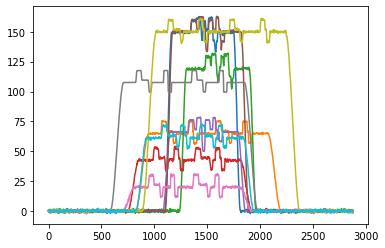

In [4]:
#
# For this machine park we consider a 24h time line of 30s samples
#
time_line= np.linspace(0,24*60*2,1000)
machines= machine_function_factory(num_machines= 10,name="machine")
for i in range(10):
    p= plt.plot(time_line,machines[i].sample(time_line))

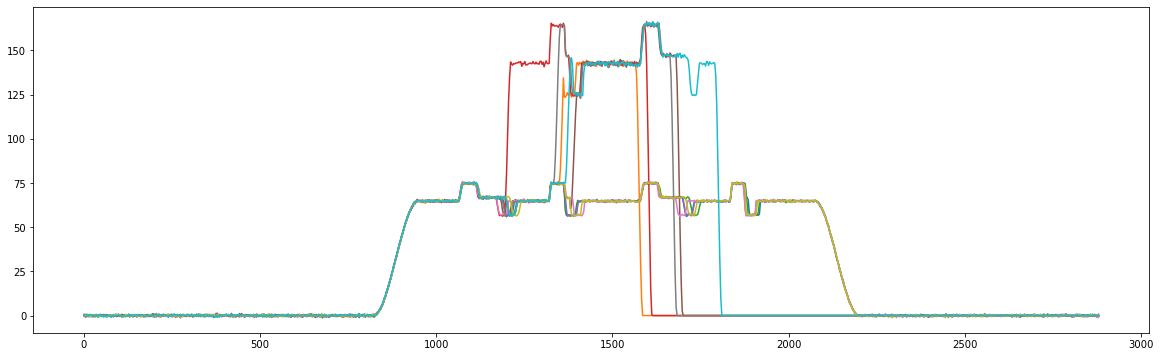

In [5]:
plt.rcParams["figure.figsize"] = (20,6)
for i in range(5):
    p= plt.plot(time_line,machines[1].sample(time_line))
    p= plt.plot(time_line,machines[1].sample_random_failure(time_line))

In [6]:
def timestamp_to_timeline(ts,tl):
    tl_length= len(tl)
    new_tl= np.zeros(tl_length)
    tl_min= min(tl)
    tl_max= max(tl)
    if tl_min < 0:
        tl_max += tl_min
        t += -tl_min
        tl_min = 0
        
    for t in ts:
        idx= 0
        if t < tl_min or t > tl_max:
            continue
        idx = int(round(t/(24) * tl_length ))
        new_tl[idx-1] = 1
    return new_tl

1
3
4
5
7


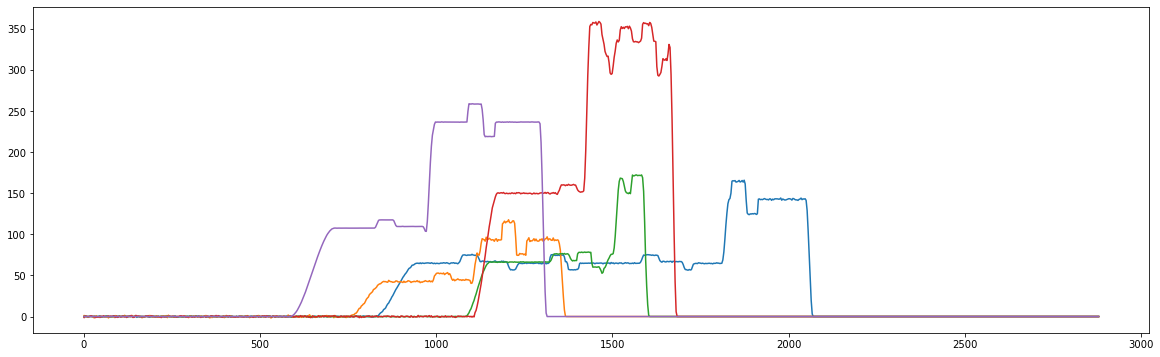

Number of failures from last sample: 5
Failures: [17.23986597040873, 11.393846721128494, 13.367563090526751, 14.019186093412317, 10.94414595723196]


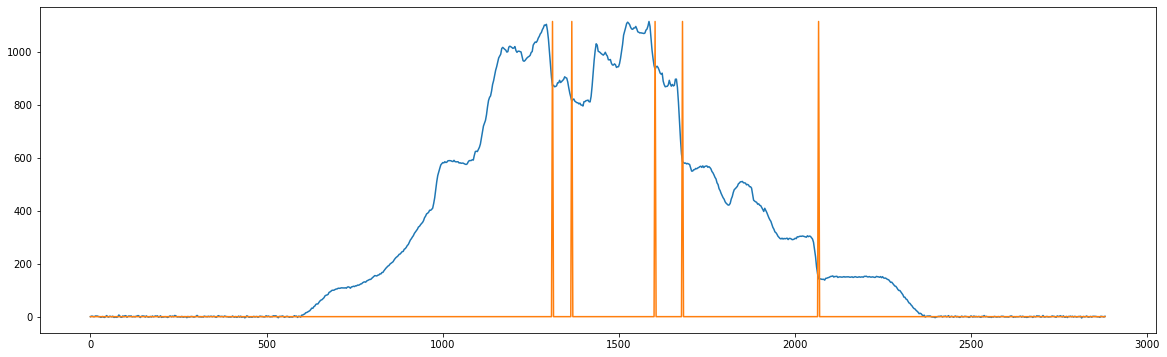

In [7]:
#
def example():
    # Create samples for all machines.
    #
    samples, E, failures = sample_machines(machines,0.4,time_line)
    for i,s in enumerate(samples):
        if machines[i].failure_time > 0:
            print (i)
            p= plt.plot(time_line,s)
    plt.show()
    p= plt.plot(time_line,E)

    tl_length= len(time_line)
    r = np.zeros(tl_length)
    tl_max = max(time_line)
    tl_min = min(time_line)
    E_max = max(E)
    print( "Number of failures from last sample: {}".format(len(failures)))
    print( "Failures: {}".format(failures))
    r = timestamp_to_timeline(failures,time_line)
    r = map(lambda x : x*E_max, r)
    p= plt.plot(time_line,[rr for rr in r])
    plt.show()
    dataset = sample_24h_workday2((samples,E,failures), 2500,200)
example()

In [8]:
def example2():
    plt.xlim(1700,2200)
    p= plt.plot(time_line,E)
    plt.vlines([2154],0,E_max)
    plt.show()

In [9]:
def example3():
    plt.xlim(2000,2500)
    p= plt.plot(time_line,samples[9])
    plt.vlines([2154],0,samples[9])
    plt.show()